# 1. KONTEKS

In [1]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import date
from scipy import stats

#Fetaure Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Model Evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
import scikitplot as skplt

#Modelling Algoritm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Deployment
import pickle

In [2]:
# memuat data
df_installment = pd.read_csv('installment_payment.csv') # data 
df_installment.drop(columns={'Unnamed: 0'},inplace=True)
df_prev = pd.read_csv('prev_app.csv')
df_prev.drop(columns={'Unnamed: 0'},inplace=True)
df_desc = pd.read_csv('columns_description.csv')

In [3]:
df_installment

,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375
1,2723183,112102,14,-197.0,-197.0,70.740,70.740
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000
...,...,...,...,...,...,...,...
2872301,1024845,407119,5,-224.0,-230.0,24819.660,24819.660
2872302,2597827,448211,18,-44.0,-44.0,915.795,915.795
2872303,2003162,450999,16,-2135.0,-2113.0,5414.265,5384.880
2872304,2149043,415032,9,-425.0,-434.0,46517.490,46517.490


Dataset installment_payment.csv adalah data histori dari tiap pinjaman (LN_ID) yang ada pada data training dan test, dan berikut adalah penjelasan pada kolom - kolom di dataset :
 -  SK_ID_PREV : ID dari pinjaman histori pada LN_ID tertentu (tiap LN_ID bisa memiliki 0,1 atau lebih SK_ID_PREV)
 -  LN_ID : ID Pinjaman aktif / sedang berjalan pada data training dan test
 -  INST_NUMBER : Cicilan keberapa yg diamati pada tiap SK_ID_PREV, e.g 1 berarti cicilan pertama, 2 berarti cicilan ke dua
 -  INST_DAYS : jatuh tempo dari cicilan pada pinjaman sebelumnya (dalam hari), e.g -176 berarti pinjaman tersebut seharusnya dibayar 176 hari yang lalu.
 -  PAY_DAYS : kapan cicilan tersebut dibayarkan oleh peminjam.
 -  AMT_INST : jumlah cicilan yang harus dibayar oleh peminjam.
 -  AMT_PAY : jumlah cicilan yg dibayar oleh peminjam.
 

Berdasarkan kolom di atas kita dapat manrik informasi penting dari dataset ini seperti :
 - Berdasarkan data histori pinjaman, berapa kali / pernahkah peminjam telat bayar (over due) atau bayar tepat waktu, ini dapat dijadikan score bagi peminjam baik score positif maupun negatif.
 - Berdasarkan data histori, berapa kali / pernahkah peminjam membayar kredit nya lebih/kurang dari jumlah yang harus dibayar.

In [4]:
df_prev

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Canceled,-14,NaN,NA1,NaN,NaN,NaN,NaN
4,1715995,447712,Cash loans,11368.620,270000.0,335754.0,NaN,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350707,1379569,309506,Cash loans,33389.100,1035000.0,1035000.0,NaN,1035000.0,THURSDAY,10,Refused,-156,60.0,low_normal,NaN,NaN,NaN,NaN
350708,1252861,363895,Cash loans,56754.000,1350000.0,1350000.0,NaN,1350000.0,THURSDAY,16,Refused,-847,48.0,middle,NaN,NaN,NaN,NaN
350709,1379406,302265,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,13,Canceled,-502,NaN,NA1,NaN,NaN,NaN,NaN
350710,2698899,161204,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,13,Canceled,-359,NaN,NA1,NaN,NaN,NaN,NaN


Sementara dataset prev_app.csv adalah dataset mengenai informasi dari pinjaman-pinjaman sebelum nya, informasi terkait jenis kontrak, biaya cicilan perbulan, jumlah pinjaman, status pinjaman tersebut (approve atau tidak), apakah disertakan DP pada cicilan ini, hari dan jam pengajuan pinjaman, jenis bunga, lama nya cicilan, dll

In [5]:
# #Melihat info dari data yang kita punya seperti jumlah kolom, input, memori, tipe data dll
df_installment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872306 entries, 0 to 2872305
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SK_ID_PREV   int64  
 1   LN_ID        int64  
 2   INST_NUMBER  int64  
 3   INST_DAYS    float64
 4   PAY_DAYS     float64
 5   AMT_INST     float64
 6   AMT_PAY      float64
dtypes: float64(4), int64(3)
memory usage: 153.4 MB


In [6]:
#Melihat info dari data yang kita punya seperti jumlah kolom, input, memori, tipe data dll
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350712 entries, 0 to 350711
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 350712 non-null  int64  
 1   LN_ID                      350712 non-null  int64  
 2   CONTRACT_TYPE              350712 non-null  object 
 3   ANNUITY                    274103 non-null  float64
 4   APPLICATION                350712 non-null  float64
 5   APPROVED_CREDIT            350712 non-null  float64
 6   AMT_DOWN_PAYMENT           164205 non-null  float64
 7   PRICE                      271072 non-null  float64
 8   WEEKDAYS_APPLY             350712 non-null  object 
 9   HOUR_APPLY                 350712 non-null  int64  
 10  CONTRACT_STATUS            350712 non-null  object 
 11  DAYS_DECISION              350712 non-null  int64  
 12  TERM_PAYMENT               274103 non-null  float64
 13  YIELD_GROUP                35

In [7]:
# melihat jumlah null value pada kolom dataset installpemnt_payment.csv
df_installment.isnull().sum()

SK_ID_PREV       0
LN_ID            0
INST_NUMBER      0
INST_DAYS        0
PAY_DAYS       673
AMT_INST         0
AMT_PAY        673
dtype: int64

In [8]:
# melihat jumlah null value pada kolom dataset prev_appp.csv
df_prev.isnull().sum()

SK_ID_PREV                        0
LN_ID                             0
CONTRACT_TYPE                     0
ANNUITY                       76609
APPLICATION                       0
APPROVED_CREDIT                   0
AMT_DOWN_PAYMENT             186507
PRICE                         79640
WEEKDAYS_APPLY                    0
HOUR_APPLY                        0
CONTRACT_STATUS                   0
DAYS_DECISION                     0
TERM_PAYMENT                  76609
YIELD_GROUP                       0
FIRST_DRAW                   139305
FIRST_DUE                    139305
TERMINATION                  139305
NFLAG_INSURED_ON_APPROVAL    139305
dtype: int64

dapat dilihat pada kolom AMT_DOWN_PAYMENT, FIRST_DRAW, FIRST_DUE, TERMINATION, NFLAG_INSURED_ON_APPROVAL jumlah null value jampir 50% dari jumlah row pada dataset. bahkan null values kolom AMT_DOWN_PAYMENT melebihi 50% dari jumlah row dataset.

# 2. DATA PRE-PROSESING

Pada tahapa ini, saya akan menyiapkan data sebelum dilakukan pemodelan. Di sini, data akan saya bersihkan dari input-input yang salah (miss input), input yang kosong, penyesuaian tipe data, normalisasi data, menghilangkan outliers, exploratory data analysis, melakukan feature engineering, dan feature selcetion, scaling, serta menangani imbalance dataset.

## 2.1 MERGING DATASET

Karena dataset train/test berhubungan dengan data installment dan prev_app maka saya akan lakukan transformasi dengan merge data berdasarkan kolom - kolom yg saling berhubungan


In [9]:
# import train dan test dataset
# drop unnamed kolom
test = pd.read_csv('app_test.csv')
test.drop(columns={'Unnamed: 0'},inplace=True)
train = pd.read_csv('app_train.csv')
train.drop(columns={'Unnamed: 0'},inplace=True)

### 2.1.1 TRAIN DATASET

Karena Train dan test dataset memiliki relational dengan data installment pada kolom LN_ID maka akan kita merge (left-join)

In [10]:
# merge data
train_merge = pd.merge(train, df_installment, how='left', on='LN_ID')
train_merge


,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,...,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,SK_ID_PREV,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,Business Entity Type 3,0.572805,0.608276,NaN,2600664.0,1.0,-550.0,-567.0,5378.715,5378.715
1,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,Business Entity Type 3,0.572805,0.608276,NaN,2600664.0,4.0,-460.0,-474.0,5378.580,5378.580
2,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,Business Entity Type 3,0.572805,0.608276,NaN,2600664.0,3.0,-490.0,-505.0,5378.715,5378.715
3,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,Business Entity Type 3,0.572805,0.608276,NaN,2600664.0,2.0,-520.0,-533.0,5378.715,5378.715
4,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,...,Other,0.655600,0.684298,NaN,1034039.0,3.0,-1608.0,-1603.0,16227.540,14617.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313772,293198,0,Cash loans,F,0,90000.0,203760.0,20281.5,180000.0,Pensioner,...,NA1,NaN,0.250811,0.644679,1176770.0,2.0,-338.0,-357.0,3948.525,3948.525
2313773,293198,0,Cash loans,F,0,90000.0,203760.0,20281.5,180000.0,Pensioner,...,NA1,NaN,0.250811,0.644679,1282329.0,11.0,-2254.0,-2330.0,2764.395,2764.395
2313774,293198,0,Cash loans,F,0,90000.0,203760.0,20281.5,180000.0,Pensioner,...,NA1,NaN,0.250811,0.644679,1418513.0,2.0,-1680.0,-1709.0,5739.255,5739.255
2313775,293198,0,Cash loans,F,0,90000.0,203760.0,20281.5,180000.0,Pensioner,...,NA1,NaN,0.250811,0.644679,1282329.0,1.0,-2554.0,-2574.0,2764.395,2764.395


In [11]:
# cek null values
train_merge.isnull().sum()

LN_ID                      0
TARGET                     0
CONTRACT_TYPE              0
GENDER                     0
NUM_CHILDREN               0
INCOME                     0
APPROVED_CREDIT            0
ANNUITY                   37
PRICE                   1623
INCOME_TYPE                0
EDUCATION                  0
FAMILY_STATUS              0
HOUSING_TYPE               0
DAYS_AGE                   0
DAYS_WORK                  0
DAYS_REGISTRATION          0
DAYS_ID_CHANGE             0
WEEKDAYS_APPLY             0
HOUR_APPLY                 0
ORGANIZATION_TYPE          0
EXT_SCORE_1          1315182
EXT_SCORE_2             2722
EXT_SCORE_3           409541
SK_ID_PREV              3194
INST_NUMBER             3194
INST_DAYS               3194
PAY_DAYS                3751
AMT_INST                3194
AMT_PAY                 3751
dtype: int64

Karena EXT_SCORE_1 dan EXT_SCORE_3 memiliki null values yang sangat banyak, maka akan kita drop kolom tersebut, lalu drop semua null values pada tiap row (karena nilai null value tiap row yg tidak banyak setelah drop 2 kolom di atas)

In [12]:
#drop column ext_score_3 dan ext_score_1
train_merge.drop(columns={'EXT_SCORE_1','EXT_SCORE_3'},inplace=True)
# drop nan value in rows
train_merge.dropna(inplace=True)
train_merge.isnull().sum()

LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
EXT_SCORE_2          0
SK_ID_PREV           0
INST_NUMBER          0
INST_DAYS            0
PAY_DAYS             0
AMT_INST             0
AMT_PAY              0
dtype: int64

setelah tidak ada null value pada tiap kolom kita akan melihat tipe kolom dan melakukan transformasi yg sesuai

In [13]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2305665 entries, 0 to 2313776
Data columns (total 27 columns):
 #   Column             Dtype  
---  ------             -----  
 0   LN_ID              int64  
 1   TARGET             int64  
 2   CONTRACT_TYPE      object 
 3   GENDER             object 
 4   NUM_CHILDREN       int64  
 5   INCOME             float64
 6   APPROVED_CREDIT    float64
 7   ANNUITY            float64
 8   PRICE              float64
 9   INCOME_TYPE        object 
 10  EDUCATION          object 
 11  FAMILY_STATUS      object 
 12  HOUSING_TYPE       object 
 13  DAYS_AGE           int64  
 14  DAYS_WORK          int64  
 15  DAYS_REGISTRATION  float64
 16  DAYS_ID_CHANGE     int64  
 17  WEEKDAYS_APPLY     object 
 18  HOUR_APPLY         int64  
 19  ORGANIZATION_TYPE  object 
 20  EXT_SCORE_2        float64
 21  SK_ID_PREV         float64
 22  INST_NUMBER        float64
 23  INST_DAYS          float64
 24  PAY_DAYS           float64
 25  AMT_INST          

setelah dianalisa tipe kolom dan value dari tiap kolom maka perlu dilakukan beberapa transformasi seperti :

- Mengubah tipe kolom DAYS_REGISTRATION, INST_DAYS, PAY_DAYS, SK_ID_PREV, INST_NUMBER menjadi int64
- Mengubah value pada kolom WEEKDAYS_APPLY menjadi angka, karena di indo seminggu dimulai pada hari senin maka saya akan set senen menjadi 1, dst
- Melakukan encoding pada kolom kategori seperti CONTRACT_TYPE, INCOME_TYPE, EDUCATION, FAMILY_STATUS, HOUSING_TYPE, DAN ORGANIZATION TYPE

In [14]:
train_merge[['DAYS_REGISTRATION','INST_DAYS','PAY_DAYS','SK_ID_PREV','INST_NUMBER']] = train_merge[['DAYS_REGISTRATION','INST_DAYS','PAY_DAYS','SK_ID_PREV','INST_NUMBER']].astype('int64')
# mengubah value dari kolom weekdays_apply menjadi nomor, 
# karena di indonesia hari pertama dalam seminggu adakah senin saya akan set monday menjadi 1, dst
train_merge['WEEKDAYS_APPLY'].replace({'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3, 'THURSDAY':4,'FRIDAY':5,'SATURDAY':6, 'SUNDAY':7},inplace=True)
# melakukan encoding pada kategori value menjadi number sehingga memudahkan model untuk memprediksi target
LE = LabelEncoder()
train_merge = pd.get_dummies(train_merge, columns=['GENDER'])
train_merge['CONTRACT_TYPE'] = LE.fit_transform(train_merge['CONTRACT_TYPE'])
train_merge['INCOME_TYPE'] = LE.fit_transform(train_merge['INCOME_TYPE'])
train_merge['EDUCATION'] = LE.fit_transform(train_merge['EDUCATION'])
train_merge['FAMILY_STATUS'] = LE.fit_transform(train_merge['FAMILY_STATUS'])
train_merge['HOUSING_TYPE'] = LE.fit_transform(train_merge['HOUSING_TYPE'])
train_merge['ORGANIZATION_TYPE'] = LE.fit_transform(train_merge['ORGANIZATION_TYPE'])
train_merge.head()


,LN_ID,TARGET,CONTRACT_TYPE,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,...,ORGANIZATION_TYPE,EXT_SCORE_2,SK_ID_PREV,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,GENDER_F,GENDER_M
0,333538,0,1,1,67500.0,202500.0,10125.0,202500.0,5,4,...,5,0.608276,2600664,1,-550,-567,5378.715,5378.715,1,0
1,333538,0,1,1,67500.0,202500.0,10125.0,202500.0,5,4,...,5,0.608276,2600664,4,-460,-474,5378.580,5378.580,1,0
2,333538,0,1,1,67500.0,202500.0,10125.0,202500.0,5,4,...,5,0.608276,2600664,3,-490,-505,5378.715,5378.715,1,0
3,333538,0,1,1,67500.0,202500.0,10125.0,202500.0,5,4,...,5,0.608276,2600664,2,-520,-533,5378.715,5378.715,1,0
4,406644,0,0,1,202500.0,976711.5,49869.0,873000.0,0,4,...,34,0.684298,1034039,3,-1608,-1603,16227.540,14617.620,1,0


In [15]:
# cek lagi info dari dataset nya
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2305665 entries, 0 to 2313776
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   LN_ID              int64  
 1   TARGET             int64  
 2   CONTRACT_TYPE      int64  
 3   NUM_CHILDREN       int64  
 4   INCOME             float64
 5   APPROVED_CREDIT    float64
 6   ANNUITY            float64
 7   PRICE              float64
 8   INCOME_TYPE        int64  
 9   EDUCATION          int64  
 10  FAMILY_STATUS      int64  
 11  HOUSING_TYPE       int64  
 12  DAYS_AGE           int64  
 13  DAYS_WORK          int64  
 14  DAYS_REGISTRATION  int64  
 15  DAYS_ID_CHANGE     int64  
 16  WEEKDAYS_APPLY     int64  
 17  HOUR_APPLY         int64  
 18  ORGANIZATION_TYPE  int64  
 19  EXT_SCORE_2        float64
 20  SK_ID_PREV         int64  
 21  INST_NUMBER        int64  
 22  INST_DAYS          int64  
 23  PAY_DAYS           int64  
 24  AMT_INST           float64
 25  AMT_PAY           

### 2.1.2 TEST DATASET

Setelah sesuai semua data pada train dataset, maka selanjutnya kita melakukan transformasi yang sama terhadap test dataset, karena data ini adalah data sama dengan train dataset namun dibagi saja.


In [16]:
# merge data
test_merge = pd.merge(test, df_installment, how='left', on='LN_ID')
test_merge.isnull().sum()

LN_ID                     0
TARGET                    0
CONTRACT_TYPE             0
GENDER                    0
NUM_CHILDREN              0
INCOME                    0
APPROVED_CREDIT           0
ANNUITY                   0
PRICE                   457
INCOME_TYPE               0
EDUCATION                 0
FAMILY_STATUS             0
HOUSING_TYPE              0
DAYS_AGE                  0
DAYS_WORK                 0
DAYS_REGISTRATION         0
DAYS_ID_CHANGE            0
WEEKDAYS_APPLY            0
HOUR_APPLY                0
ORGANIZATION_TYPE         0
EXT_SCORE_1          316247
EXT_SCORE_2             428
EXT_SCORE_3           99279
SK_ID_PREV              769
INST_NUMBER             769
INST_DAYS               769
PAY_DAYS                885
AMT_INST                769
AMT_PAY                 885
dtype: int64

Karena EXT_SCORE_1 dan EXT_SCORE_3 memiliki null values yang sangat banyak, maka akan kita drop kolom tersebut, lalu drop semua null values pada tiap row (karena nilai null value tiap row yg tidak banyak setelah drop 2 kolom di atas)

In [17]:
#drop column ext_score_3 dan ext_score_1
test_merge.drop(columns={'EXT_SCORE_1','EXT_SCORE_3'},inplace=True)
# drop nan value in rows
test_merge.dropna(inplace=True)
test_merge.isnull().sum()

LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
EXT_SCORE_2          0
SK_ID_PREV           0
INST_NUMBER          0
INST_DAYS            0
PAY_DAYS             0
AMT_INST             0
AMT_PAY              0
dtype: int64

setelah tidak ada null value pada tiap kolom kita akan melihat tipe kolom dan melakukan transformasi yg sesuai

In [18]:
# check info
test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560727 entries, 0 to 562491
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LN_ID              560727 non-null  int64  
 1   TARGET             560727 non-null  int64  
 2   CONTRACT_TYPE      560727 non-null  object 
 3   GENDER             560727 non-null  object 
 4   NUM_CHILDREN       560727 non-null  int64  
 5   INCOME             560727 non-null  float64
 6   APPROVED_CREDIT    560727 non-null  float64
 7   ANNUITY            560727 non-null  float64
 8   PRICE              560727 non-null  float64
 9   INCOME_TYPE        560727 non-null  object 
 10  EDUCATION          560727 non-null  object 
 11  FAMILY_STATUS      560727 non-null  object 
 12  HOUSING_TYPE       560727 non-null  object 
 13  DAYS_AGE           560727 non-null  int64  
 14  DAYS_WORK          560727 non-null  int64  
 15  DAYS_REGISTRATION  560727 non-null  float64
 16  DA

setelah dianalisa tipe kolom dan value dari tiap kolom maka perlu dilakukan beberapa transformasi seperti :

- Mengubah tipe kolom DAYS_REGISTRATION, INST_DAYS, PAY_DAYS, SK_ID_PREV, INST_NUMBER menjadi int64
- Mengubah value pada kolom WEEKDAYS_APPLY menjadi angka, karena di indo seminggu dimulai pada hari senin maka saya akan set senen menjadi 1, dst
- Melakukan encoding pada kolom kategori seperti CONTRACT_TYPE, INCOME_TYPE, EDUCATION, FAMILY_STATUS, HOUSING_TYPE, DAN ORGANIZATION TYPE

In [19]:
test_merge[['DAYS_REGISTRATION','INST_DAYS','PAY_DAYS','SK_ID_PREV','INST_NUMBER']] = test_merge[['DAYS_REGISTRATION','INST_DAYS','PAY_DAYS','SK_ID_PREV','INST_NUMBER']].astype('int64')
# mengubah value dari kolom weekdays_apply menjadi nomor, 
# karena di indonesia hari pertama dalam seminggu adakah senin saya akan set monday menjadi 1, dst
test_merge['WEEKDAYS_APPLY'].replace({'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3, 'THURSDAY':4,'FRIDAY':5,'SATURDAY':6, 'SUNDAY':7},inplace=True)
# melakukan encoding pada kategori value menjadi number sehingga memudahkan model untuk memprediksi target
test_merge = pd.get_dummies(test_merge, columns=['GENDER'])
test_merge['CONTRACT_TYPE'] = LE.fit_transform(test_merge['CONTRACT_TYPE'])
test_merge['INCOME_TYPE'] = LE.fit_transform(test_merge['INCOME_TYPE'])
test_merge['EDUCATION'] = LE.fit_transform(test_merge['EDUCATION'])
test_merge['FAMILY_STATUS'] = LE.fit_transform(test_merge['FAMILY_STATUS'])
test_merge['HOUSING_TYPE'] = LE.fit_transform(test_merge['HOUSING_TYPE'])
test_merge['ORGANIZATION_TYPE'] = LE.fit_transform(test_merge['ORGANIZATION_TYPE'])
test_merge.head()


,LN_ID,TARGET,CONTRACT_TYPE,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,...,ORGANIZATION_TYPE,EXT_SCORE_2,SK_ID_PREV,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,GENDER_F,GENDER_M
0,219092,0,0,3,135000.0,871029.0,44604.0,765000.0,3,4,...,5,0.145475,2487385,7,-1530,-1534,8829.270,8829.270,0,1
1,219092,0,0,3,135000.0,871029.0,44604.0,765000.0,3,4,...,5,0.145475,1793513,8,-1287,-1332,4327.875,265.050,0,1
2,219092,0,0,3,135000.0,871029.0,44604.0,765000.0,3,4,...,5,0.145475,2487385,4,-1620,-1629,8829.270,8829.270,0,1
3,219092,0,0,3,135000.0,871029.0,44604.0,765000.0,3,4,...,5,0.145475,2487385,9,-1470,-1503,8829.270,8829.270,0,1
4,219092,0,0,3,135000.0,871029.0,44604.0,765000.0,3,4,...,5,0.145475,1793513,7,-1317,-1332,4327.875,4327.875,0,1


In [20]:
# cek lagi info dari dataset nya
test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560727 entries, 0 to 562491
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LN_ID              560727 non-null  int64  
 1   TARGET             560727 non-null  int64  
 2   CONTRACT_TYPE      560727 non-null  int64  
 3   NUM_CHILDREN       560727 non-null  int64  
 4   INCOME             560727 non-null  float64
 5   APPROVED_CREDIT    560727 non-null  float64
 6   ANNUITY            560727 non-null  float64
 7   PRICE              560727 non-null  float64
 8   INCOME_TYPE        560727 non-null  int64  
 9   EDUCATION          560727 non-null  int64  
 10  FAMILY_STATUS      560727 non-null  int64  
 11  HOUSING_TYPE       560727 non-null  int64  
 12  DAYS_AGE           560727 non-null  int64  
 13  DAYS_WORK          560727 non-null  int64  
 14  DAYS_REGISTRATION  560727 non-null  int64  
 15  DAYS_ID_CHANGE     560727 non-null  int64  
 16  WE

## 2.2 HANDLING OUTLIERS

Saya akan melihat apakah ada outlier di data kita dan akan kita coba untuk menanganinya agar tidak teradi salah interpretasi terhadap target varibel kita. Namun kita perlu cek juga apakah outlier ini salah input atau memang dia anomali.

### 2.2.1 TRAIN DATASET 


In [21]:
# Saya akan menggunakan Inter Quartile Range untuk menangani ouliers
# Menentukan Limit
def limit(data,i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

#Mengitung persen outliers dari data    
def percent_outliers(data,i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    #melihat persenan outliers terhadap total data
    print('Lower Limit: {} %'.format(data[(data[i] < lower_limit)].shape[0]/ data.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(data[(data[i] < lower_limit_extreme)].shape[0]/data.shape[0]*100))
    print('Upper Limit: {} %'.format(data[(data[i] > upper_limit)].shape[0]/ data.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(data[(data[i] > upper_limit_extreme)].shape[0]/data.shape[0]*100))

In [22]:
test_merge.shape[0]/train_merge.shape[0]

0.2431953471124383

untuk memudahkan melakukan cleaning saya akan merge data train dan test

In [23]:
clean_concat = pd.concat([train_merge, test_merge])
clean_concat.shape

(2866392, 28)

Text(0.5, 0, 'Jumlah')

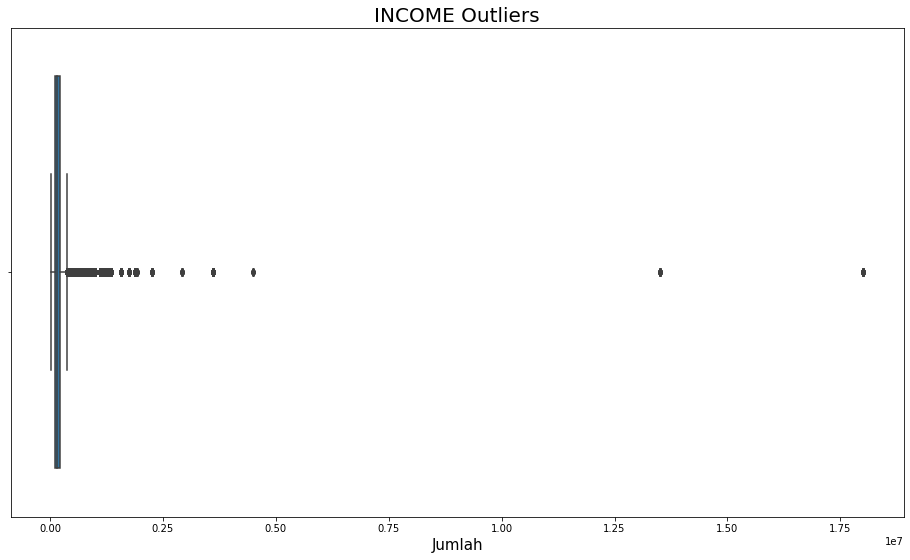

In [24]:
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['INCOME'])
plt.title('INCOME Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [25]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'INCOME'))
print('-'*50)
print(percent_outliers(clean_concat,'INCOME'))

Lower Limit: -42750.0
Lower Limit Extreme: -198000.0
Upper Limit: 371250.0
Upper Limit Extreme: 526500.0
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 3.1067279004406934 %
Upper Limit Extereme: 0.8125894853181282 %
None


Text(0.5, 0, 'Jumlah')

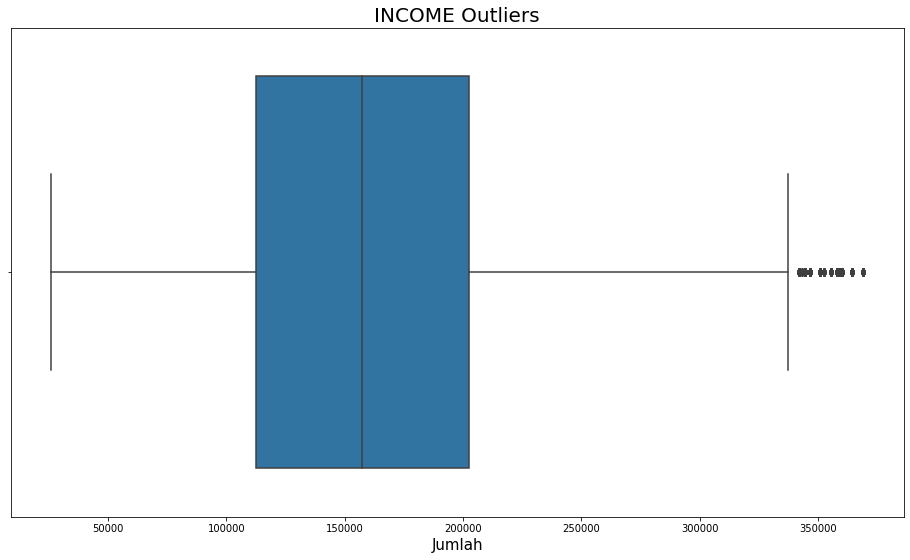

In [26]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.INCOME >371250.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['INCOME'])
plt.title('INCOME Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [27]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'INCOME'))
print('-'*50)
print(percent_outliers(clean_concat,'INCOME'))

Lower Limit: -22500.0
Lower Limit Extreme: -157500.0
Upper Limit: 337500.0
Upper Limit Extreme: 472500.0
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 1.809482798820224 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

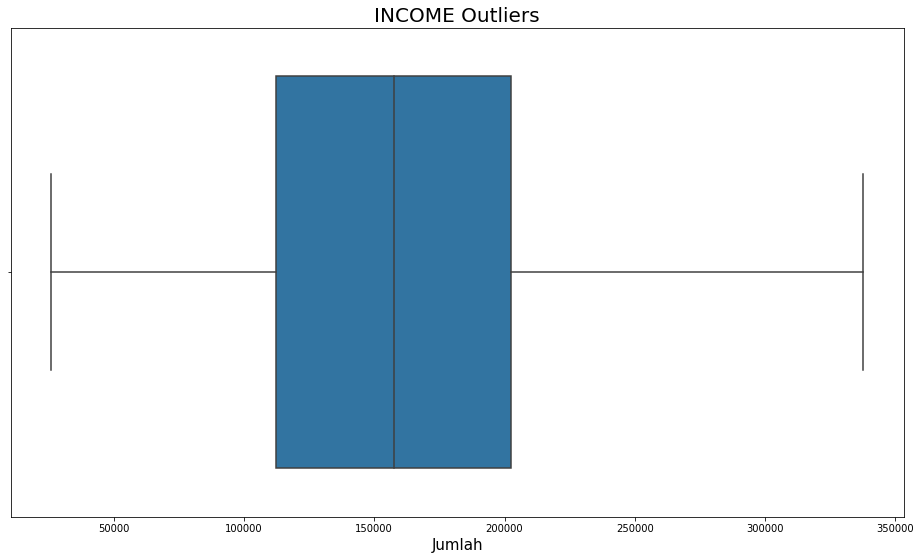

In [28]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.INCOME >337500.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['INCOME'])
plt.title('INCOME Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

Text(0.5, 0, 'Jumlah')

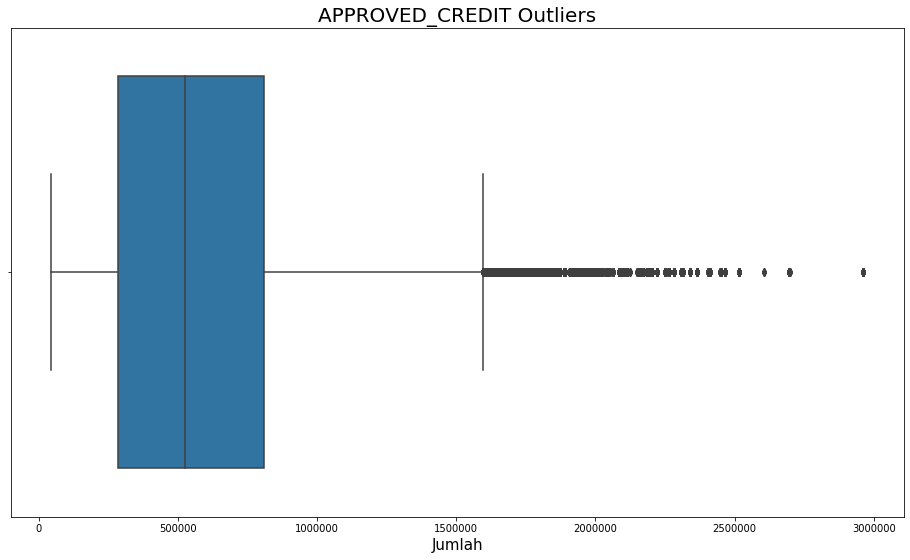

In [29]:
# cek outliers pada kolom APPROVED_CREDIT
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['APPROVED_CREDIT'])
plt.title('APPROVED_CREDIT Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [30]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'APPROVED_CREDIT'))
print('-'*50)
print(percent_outliers(clean_concat,'APPROVED_CREDIT'))

Lower Limit: -501975.0
Lower Limit Extreme: -1288350.0
Upper Limit: 1595025.0
Upper Limit Extreme: 2381400.0
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 1.6330877486502922 %
Upper Limit Extereme: 0.02904162994468279 %
None


Text(0.5, 0, 'Jumlah')

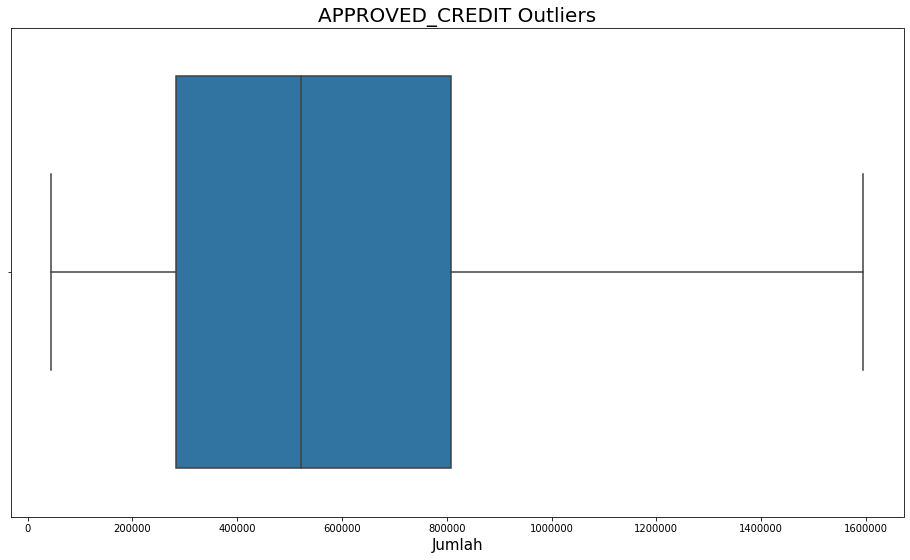

In [31]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.APPROVED_CREDIT > 1595025.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['APPROVED_CREDIT'])
plt.title('APPROVED_CREDIT Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

Text(0.5, 0, 'Jumlah')

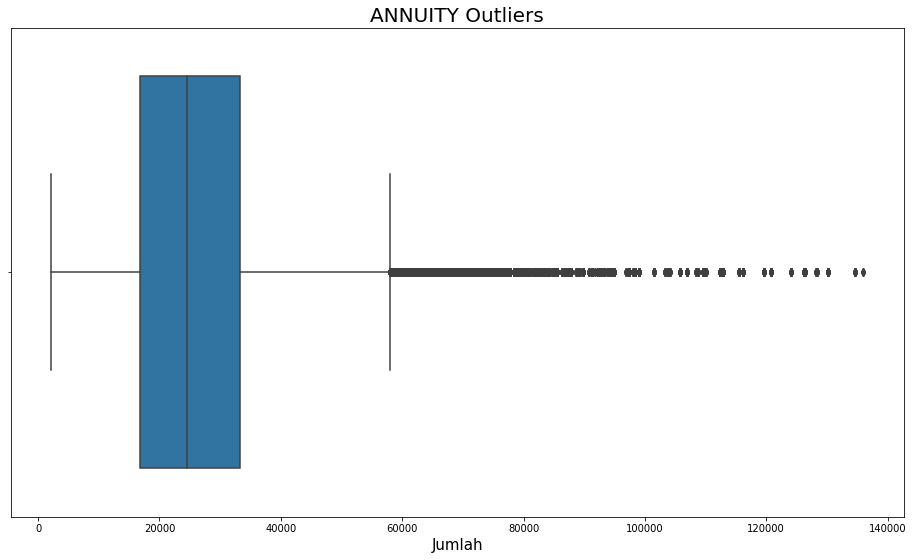

In [32]:
# cek outliers pada kolom ANNUITY
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['ANNUITY'])
plt.title('ANNUITY Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [33]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'ANNUITY'))
print('-'*50)
print(percent_outliers(clean_concat,'ANNUITY'))

Lower Limit: -7818.75
Lower Limit Extreme: -32476.5
Upper Limit: 57935.25
Upper Limit Extreme: 82593.0
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 1.5795383922694886 %
Upper Limit Extereme: 0.18896669920583534 %
None


Text(0.5, 0, 'Jumlah')

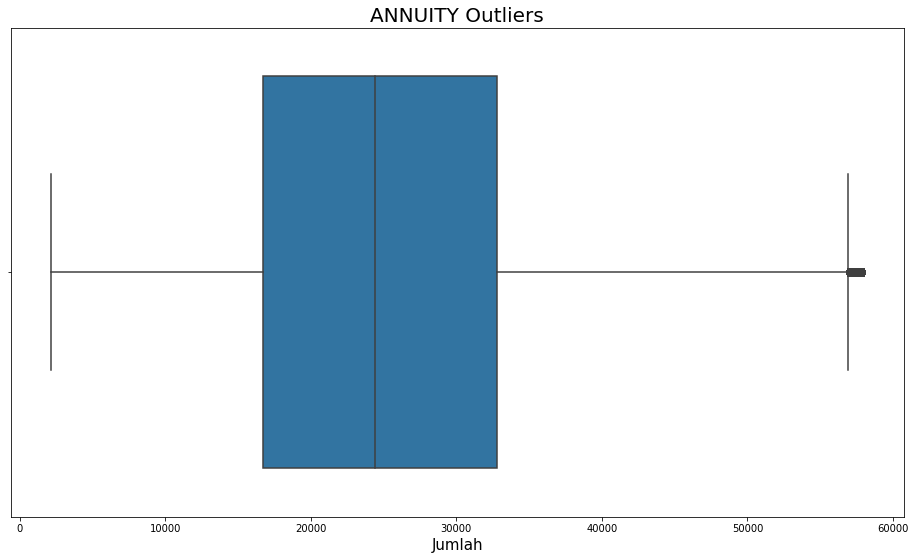

In [34]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.ANNUITY > 57935.25].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['ANNUITY'])
plt.title('ANNUITY Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [35]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'ANNUITY'))
print('-'*50)
print(percent_outliers(clean_concat,'ANNUITY'))

Lower Limit: -7443.0
Lower Limit Extreme: -31567.5
Upper Limit: 56889.0
Upper Limit Extreme: 81013.5
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.28031263747039625 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

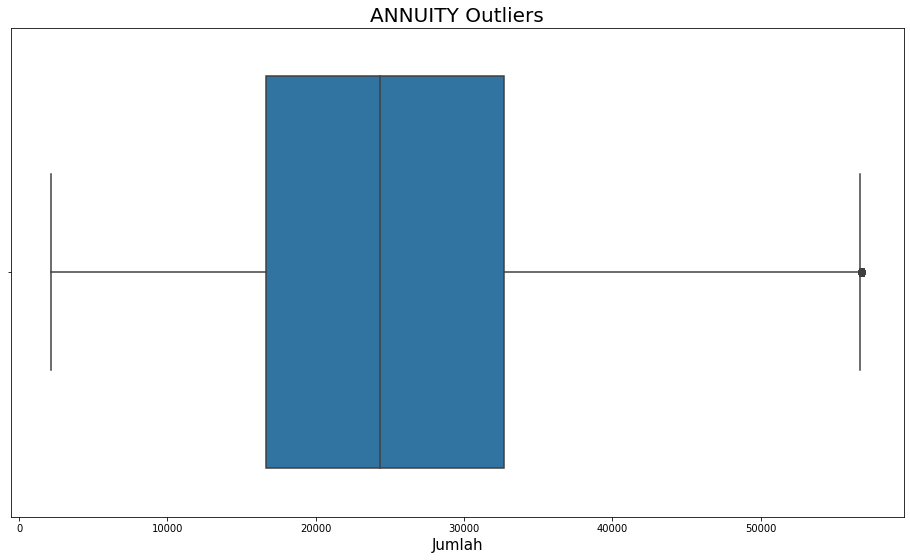

In [36]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.ANNUITY >56889.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['ANNUITY'])
plt.title('ANNUITY Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [37]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'ANNUITY'))
print('-'*50)
print(percent_outliers(clean_concat,'ANNUITY'))

Lower Limit: -7362.0
Lower Limit Extreme: -31378.5
Upper Limit: 56682.0
Upper Limit Extreme: 80698.5
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.02842925429085676 %
Upper Limit Extereme: 0.0 %
None


karena data outlier kurang dari 0.05 maka akan kita biarkan saja

Text(0.5, 0, 'Jumlah')

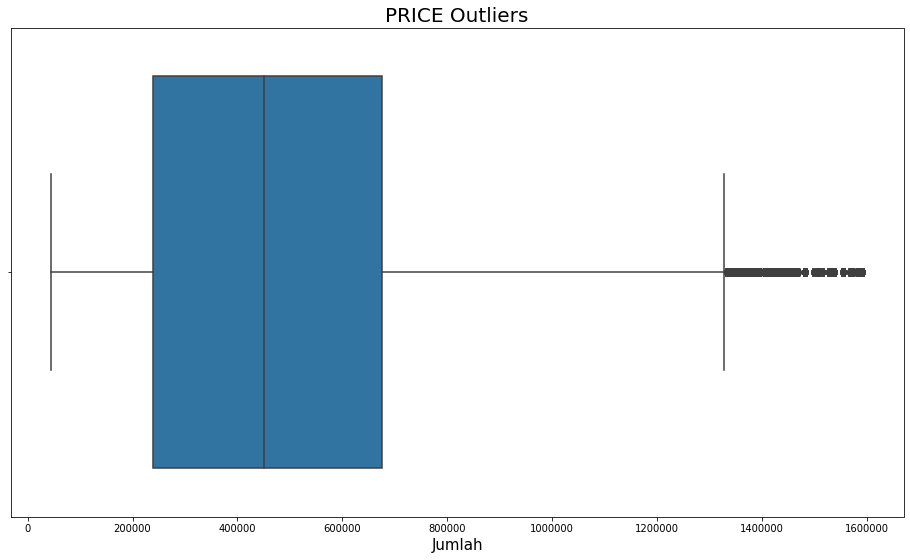

In [38]:
# saya akan cek ouliers kolom PRICE
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['PRICE'])
plt.title('PRICE Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [39]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'PRICE'))
print('-'*50)
print(percent_outliers(clean_concat,'PRICE'))

Lower Limit: -416250.0
Lower Limit Extreme: -1071000.0
Upper Limit: 1329750.0
Upper Limit Extreme: 1984500.0
None
--------------------------------------------------
Lower Limit: 0.0 %
Lower Limit Extereme: 0.0 %
Upper Limit: 2.0085170124578955 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

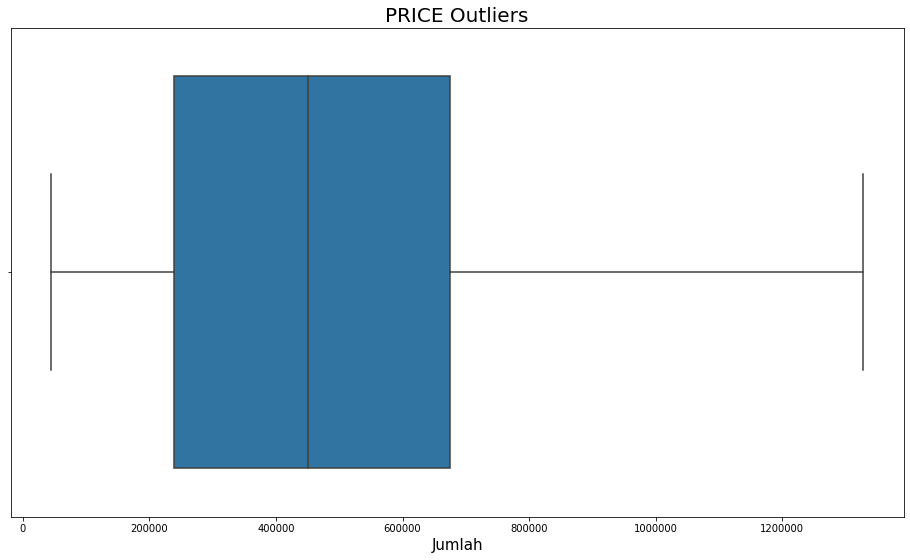

In [40]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.PRICE >1329750.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['PRICE'])
plt.title('PRICE Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [41]:
# clean_concat.LN_ID.dtypes == 'int64'

In [42]:
# int_col = [col for col in clean_concat.columns if clean_concat[col].dtype == 'int64']
# int_col.remove('LN_ID')
# int_col.remove('TARGET')
# int_col.remove('CONTRACT_TYPE')
# int_col.remove('NUM_CHILDREN')
# int_col.remove('INCOME_TYPE')
# int_col.remove('EDUCATION')
# int_col.remove('FAMILY_STATUS')
# int_col.remove('HOUSING_TYPE')
# int_col.remove('WEEKDAYS_APPLY')
# int_col.remove('ORGANIZATION_TYPE')
# for i in int_col:
#     # saya akan cek distribusi tiap kolom 
#     f, ax = plt.subplots(figsize=(16,9))
#     sns.boxplot(x=clean_concat[i])
#     plt.title(f'{i} Outliers', fontsize=20)
#     plt.xlabel('Jumlah', fontsize=15)

Ada 4 kolom int64 yang memiliki outliers, yaitu :
- DAYS_WORK
- DAYS_REGISTRATION
- HOUR_APPLY
- INST_NUMBER

kita tidak akan remove outliers hour apply karena ini adalah data real dan tidak mungkin salah input

Setelah di analisaoutliers pada kolom DAYS_WORK seperti nya merupakan salah input dimana value 365243 seharusnya 365.25 (1 tahun dalam hari), maka saya akan mengganti value tsb

In [43]:
clean_concat[clean_concat.DAYS_WORK > 0]['DAYS_WORK'].unique()

array([365243])

Text(0.5, 0, 'Jumlah')

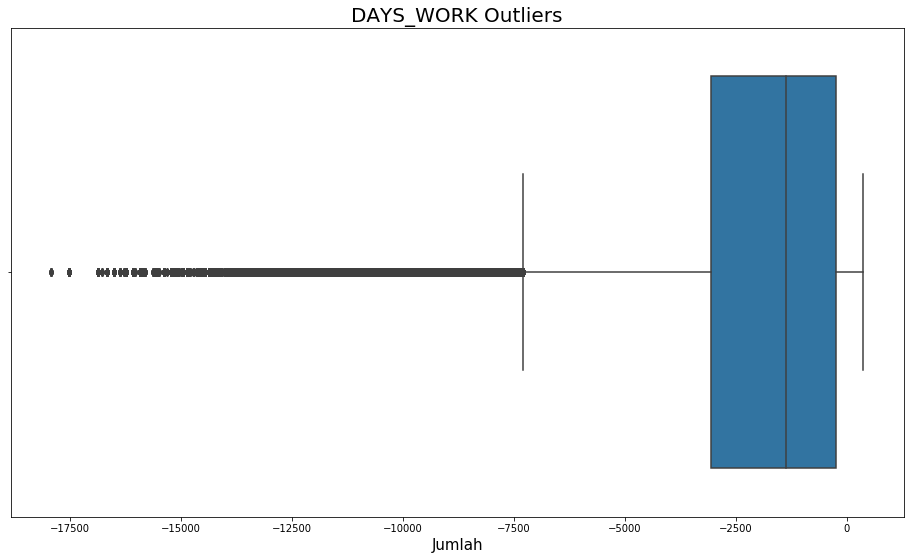

In [44]:
clean_concat['DAYS_WORK'] = clean_concat['DAYS_WORK'].replace({365243:365})
# saya akan cek distribusi kolom DAYS_WORK
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_WORK'])
plt.title('DAYS_WORK Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [45]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_WORK'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_WORK'))

Lower Limit: -7292.0
Lower Limit Extreme: -11525.0
Upper Limit: 3996.0
Upper Limit Extreme: 8229.0
None
--------------------------------------------------
Lower Limit: 4.570456743560648 %
Lower Limit Extereme: 0.8830582285905106 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

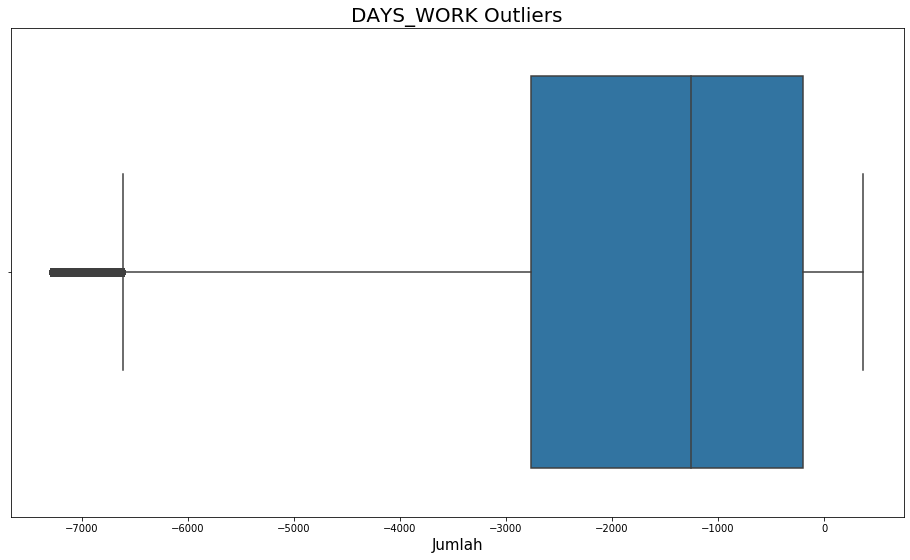

In [46]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.DAYS_WORK < -7286.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_WORK'])
plt.title('DAYS_WORK Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [47]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_WORK'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_WORK'))

Lower Limit: -6609.0
Lower Limit Extreme: -10455.0
Upper Limit: 3647.0
Upper Limit Extreme: 7493.0
None
--------------------------------------------------
Lower Limit: 1.2546099491650382 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

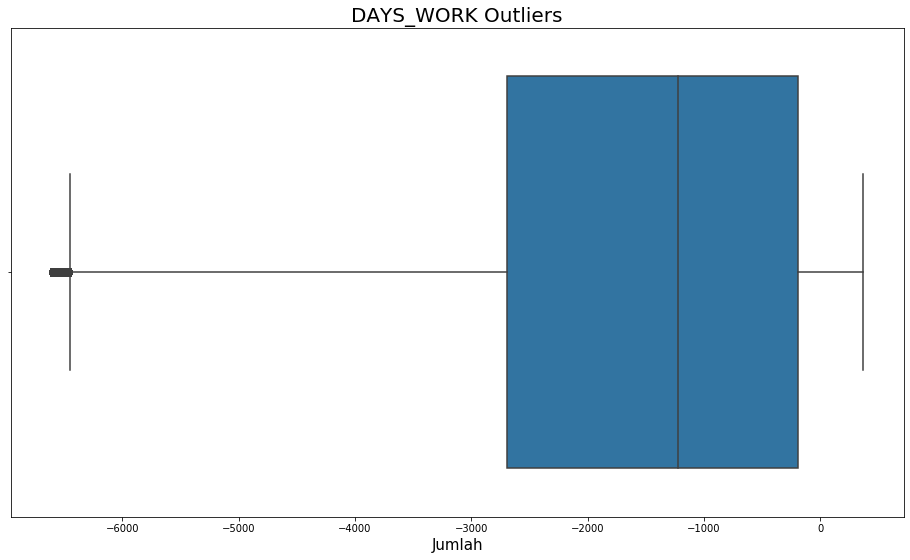

In [48]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.DAYS_WORK < -6610.5].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_WORK'])
plt.title('DAYS_WORK Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [49]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_WORK'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_WORK'))

Lower Limit: -6451.5
Lower Limit Extreme: -10209.0
Upper Limit: 3568.5
Upper Limit Extreme: 7326.0
None
--------------------------------------------------
Lower Limit: 0.29627386195968425 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

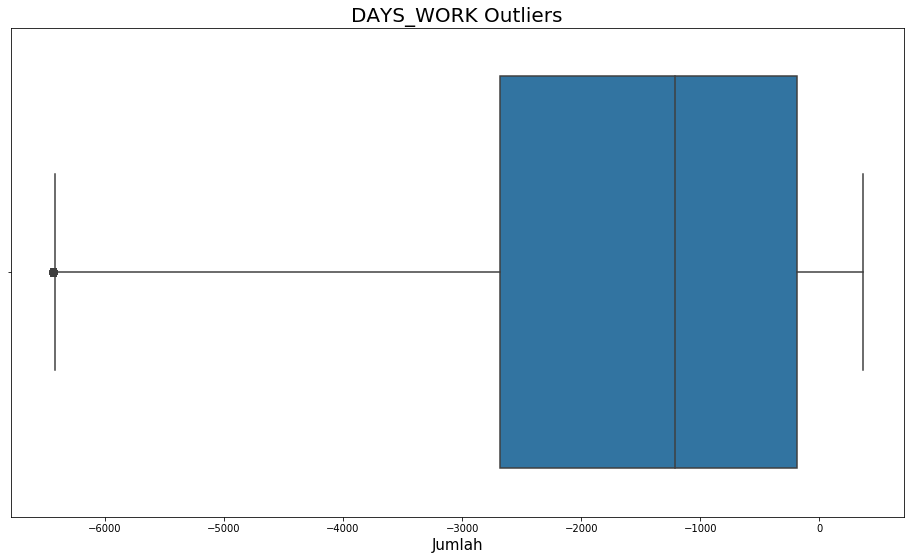

In [50]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.DAYS_WORK < -6451.5].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_WORK'])
plt.title('DAYS_WORK Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [51]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_WORK'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_WORK'))

Lower Limit: -6418.0
Lower Limit Extreme: -10156.0
Upper Limit: 3550.0
Upper Limit Extreme: 7288.0
None
--------------------------------------------------
Lower Limit: 0.09948752965451531 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


Text(0.5, 0, 'Jumlah')

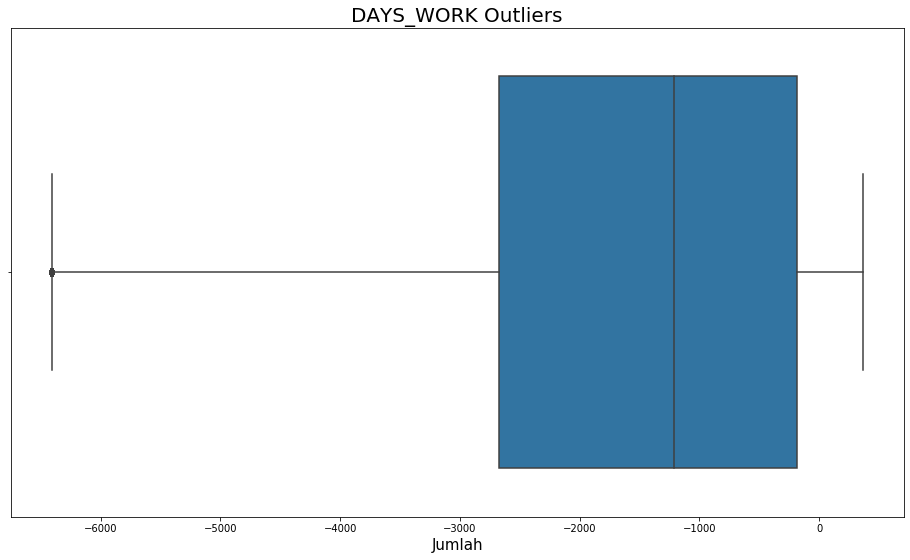

In [52]:
# karena kurang dari 5% data maka akan saya drop outliers ini
clean_concat.drop(index=clean_concat[clean_concat.DAYS_WORK < -6414.5].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_WORK'])
plt.title('DAYS_WORK Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [53]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_WORK'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_WORK'))

Lower Limit: -6403.5
Lower Limit Extreme: -10134.0
Upper Limit: 3544.5
Upper Limit Extreme: 7275.0
None
--------------------------------------------------
Lower Limit: 0.01456912258775702 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


karena lebih kecil dari 0.05 % maka akan kita biarkan saja outliers ini

Text(0.5, 0, 'Jumlah')

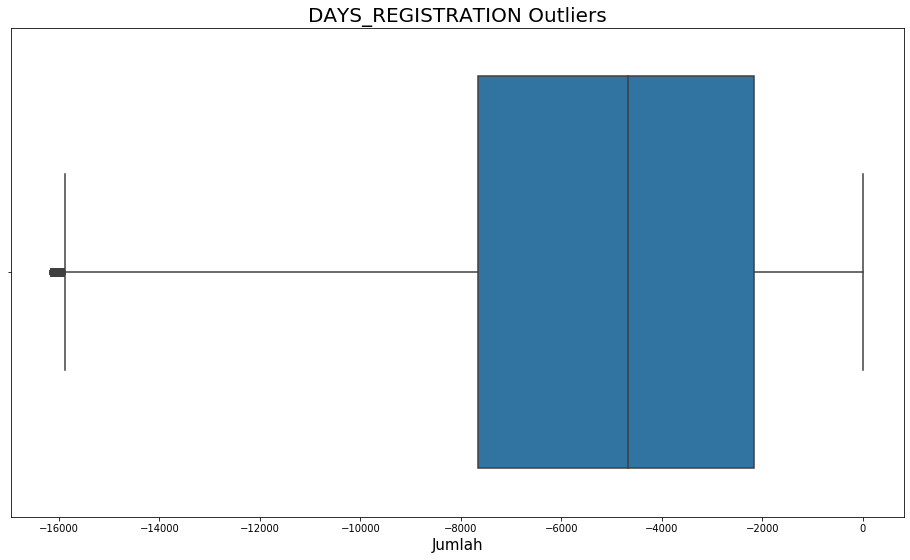

In [54]:
# karena kurang dari 5% data maka akan saya drop outliers pada kolom DAYS_REGISTRATION ini
clean_concat.drop(index=clean_concat[clean_concat.DAYS_REGISTRATION < -16172.0].index, inplace=True)
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['DAYS_REGISTRATION'])
plt.title('DAYS_REGISTRATION Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [55]:
# saya akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit(clean_concat,'DAYS_REGISTRATION'))
print('-'*50)
print(percent_outliers(clean_concat,'DAYS_REGISTRATION'))

Lower Limit: -15883.5
Lower Limit Extreme: -24108.0
Upper Limit: 6048.5
Upper Limit Extreme: 14273.0
None
--------------------------------------------------
Lower Limit: 0.042664255183267163 %
Lower Limit Extereme: 0.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


karena kurang dari 0.05 % maka akn saya biarkan outliers ini

Text(0.5, 0, 'Jumlah')

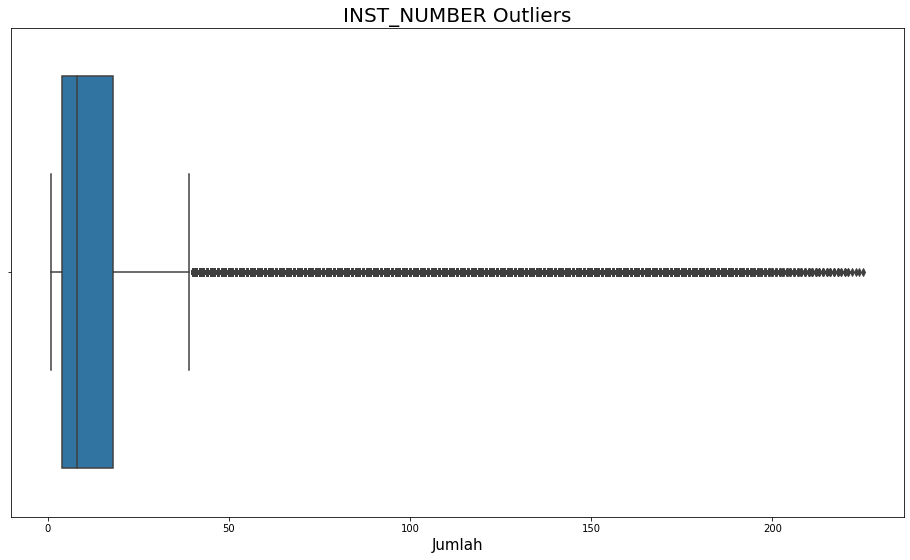

In [56]:
# saya akan cek distribusi kolom INCOME
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=clean_concat['INST_NUMBER'])
plt.title('INST_NUMBER Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [57]:
clean_concat.shape

(2273566, 28)

Pada data ini saya tidak akan drop outliers karena bisa saja suatu LN_ID memiliki INST_NUMBER lebih dari 100 apabila data histori ini sangat lama (misal 20 thn dan term payment mereka sedikit (hanya 3 bulan))

## 2.3 FEATURE SELECTION

Tahap ini saya akan memilih atau mencari feature mana saja yang paling relefan dengan target saya. Saya suda mencoba dengan menggunakan KBest dan Feature Importance dan saya juga tidak memnggunkan corelation coeficient karena target variabelnya dan ada beberapa independen variabel yang kategorikal. Namun setela dimasukkan ke dalam model yang paling bagus adalah Fetaure Importance.

/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


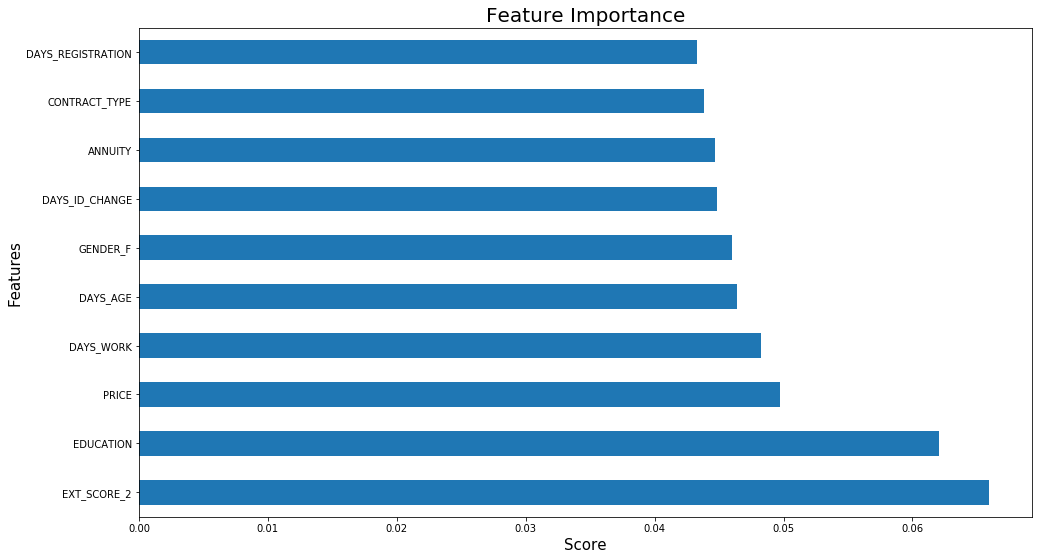

In [58]:
#karena data memiliki jumlah input yang sangat banyak, maka saya akan menggunakan teknik feature importance pada fetaure selection
#kita akan memisahkan dulu independen dan dependen featurenya
#data = data.reset_index(drop=True) #reset index dulu biar urut indexnya
# membagi data Y (TARGET) dan X (variabel)
X = clean_concat.drop(columns={'TARGET'})
y = clean_concat['TARGET']

#kita coba menggunakan fetaure importance pada model XGboost
model = XGBClassifier()
model.fit(X,y)

#Kita visualisasi feature yang penting-penting
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
f, ax = plt.subplots(figsize=(16,9))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.show()

Bisa dilihat bahwa grafik di atas menunjukan 3 variabel yang memiliki pengaruh terbesar pada target :
1. EXT_SCORE_2 = merupakan score yang diberikan terhadap loaners dari data eksternal, score ini sepertinya merujuk pada credit score mereka, setelah dilakukan analisa 
    -   rata2 EXT_SCORE_2 untuk loaners dengan TARGET 1 lebih kecil dari pada score untuk loaners dengan TARGET 0
    -   semakin bagus history installment pada loaners, maka seharusnya EXT_SCORE_2 akan semakin bagus
2. HOUSING_TYPE = merupakan kondisi kepemilikan rumah dari loaners, tentu saja ini menjadi variabel penting, selain income kondisi kepemilikan rumah lebih menentukan kemapanan dan kemandirian finansial seseorang, contoh seorang dengan income tinggi apabila belum mempunyai rumah maka mereka akan cenderung belum mapan karena harus membeli / mencicil rumah ke depannya. 
3. EDUCATION = merupakan tingkat pendidikan tertinggi dari client/loaners. sudah sewajarnya variabel ini menjadi variabel terpenting karena, pada income atau pendapatan seseorang berbanding lurus dengan pendidikan atau ilmu mereka, semakin tinggi ilmu atau pendidikan nya pendapatan atau ekpektasi hidup mereka pasti lebih besaar. 


Karena kolom GENDER_M dan AMT_INST tidak memiliki feture importance maka akan kita drop

In [59]:
X_select = clean_concat[['EXT_SCORE_2','EDUCATION','PRICE','DAYS_WORK','DAYS_AGE','GENDER_F','DAYS_ID_CHANGE','ANNUITY','CONTRACT_TYPE','DAYS_REGISTRATION']]
X_select

,EXT_SCORE_2,EDUCATION,PRICE,DAYS_WORK,DAYS_AGE,GENDER_F,DAYS_ID_CHANGE,ANNUITY,CONTRACT_TYPE,DAYS_REGISTRATION
0,0.608276,4,202500.0,-921,-11539,1,-2757,10125.0,1,-119
1,0.608276,4,202500.0,-921,-11539,1,-2757,10125.0,1,-119
2,0.608276,4,202500.0,-921,-11539,1,-2757,10125.0,1,-119
3,0.608276,4,202500.0,-921,-11539,1,-2757,10125.0,1,-119
4,0.684298,4,873000.0,-4482,-15743,1,-2455,49869.0,0,-1797
...,...,...,...,...,...,...,...,...,...,...
562487,0.381569,4,225000.0,-387,-12782,1,-4823,20299.5,0,-1261
562488,0.381569,4,225000.0,-387,-12782,1,-4823,20299.5,0,-1261
562489,0.381569,4,225000.0,-387,-12782,1,-4823,20299.5,0,-1261
562490,0.381569,4,225000.0,-387,-12782,1,-4823,20299.5,0,-1261


In [60]:
# clean_concat = clean_concat.drop(columns={'GENDER_M','AMT_INST'})
# clean_concat.shape

## 2.4 IMBALANCE DATASET

Karena ini adalah problem klasifikasi dan target variabel pada dataset ini memiliki perbandingan yang sangat jauh kerena persentase yang gagal bayar pasti lebih sedikit dibandingkan dengan yang berhasil, sehingga kita perlu menangani hal ini agar ketika nanti masuk ke dalam model tidak teradi bias karena terjadinya perbedaan ration apda target variabel.

In [61]:
#Kita cek ratio target variabel
print(clean_concat.TARGET.value_counts())
print('-'*50)
print('TARGET (0): {} %'.format(clean_concat[(clean_concat['TARGET'] == 0)].shape[0]/clean_concat.shape[0]*100))
print('TARGET (1): {} %'.format(clean_concat[(clean_concat['TARGET'] == 1)].shape[0]/clean_concat.shape[0]*100))

0    2094837
1     178729
Name: TARGET, dtype: int64
--------------------------------------------------
TARGET (0): 92.13882508798953 %
TARGET (1): 7.861174912010471 %


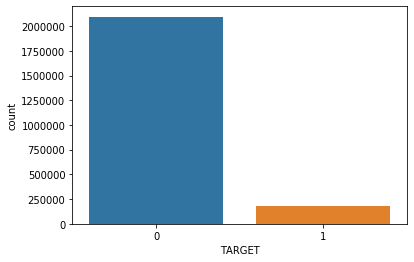

In [62]:
#Visualisasi Imbalance Dataset Sebelum Dibenahi
sns.countplot("TARGET",data=clean_concat)

bisa dilihat bahwa target variabel kita imbalance atau tidak seimbang, 0 (other case): 92.14% dan 1(client with late payment more than X days): 7.86% sehingga kita akan menangani masalah ini, karena jika tidak model akan lebih cenderung memprediksi 0 karena lebih banyak dalam jumlah

split train data and test data, menjadi 0.75 dan 0.25 dari total data secara berurutan

In [63]:
# membagi data Y (TARGET) dan X (variabel)
X = X_select
y = clean_concat['TARGET']
# scaled data X agar normalization range dari data - data tiap kolom
S = StandardScaler()
X_Scaled = S.fit_transform(X)
# split train and test dengan data X_Scaled dan y dengan stratify = y karena data target kita (y) tidak seimbang atau imbalance
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.25, random_state=3, stratify=y)

In [64]:
X.shape

(2273566, 10)

In [65]:
y.shape

(2273566,)

# 3. MODELLING

Setelah semua data sudah bersih dan siap dimasukkan ke dalam model, maka ini saatnya kita membuat model dan mencari model yang paling optimal. Disini saya langsung evaluasii setela membuat model, dilatih dan dites agar memudahkan melihat model mana yang paling optimal.

pada Model ini saya menggunakan 3 Evaluasi Metrik yaitu :
1. Confusion Matrix = Confusion Matrix adalah teknik evaluasi untuk mengukur performance dari suatu klasifikasi model/algoritma. Karena Target variabel kita mempunyai 2 class (0 dan 1) dan sudah dilakukan balancing maka confusion matrix merupakan teknik evaluasi yang tepat. ketika membuat prediksi pada binari model atau 2-class klasifikasi model , terdapat 2 Error yang muncul pada prediksi yaitu False Positive (ketika memprediksi suatu Target 1 namun aktual nya Target 0) dan False Negative (ketika memprediksi suatu Target 0 namun aktual nya Target 1), dan Confusion Matrix dapat merepresentasikan Error ini dengan sangat baik.

2. ROC Curve = ROC curve merepresentasikan atau memplot trade-off antara false positive rate versus true positive rate. 
    - True Positive Rate / Sensitivity = True Positive / (True Positive + False Negative)
    - False Positive Rate = False Positive / (False Positive + False Positive).

    ROC Curve juga sangat efektik karena : 
    - AUC (Area Under Curve) dapat merepresentasikan skill dari model, semakin besar AUC, semakin bagus model.

3. Precision and Recall Curve = Precision and Recall Curve merepresentasikan atau memplot tradfe-off antara True Positive Rate dengan Positive Predicted Value
    - Precision = True Positive / (True Positive + False Positive)
    - Recall = True Positive / (True Positive + False Negative)
    
    Precision and Recall sangat efektif ketika memiliki imbalanced dataset seperti dataset ini. 

In [66]:
#Membuat fungsi yang nanti sekalin bisa training dan tes kemudian dievalusi
def model_eval(algo,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:,-1]

    #TEST

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,-1]
    y_probas = algo.predict_proba(X_test)
    
    #Confussion Matrix
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    #ROC Curve
    #fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #PR Curve
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()

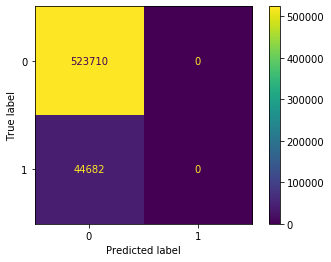

/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification Report: 
               precision    recall  f1-score   support

           0      0.921     1.000     0.959    523710
           1      0.000     0.000     0.000     44682

    accuracy                          0.921    568392
   macro avg      0.461     0.500     0.480    568392
weighted avg      0.849     0.921     0.884    568392



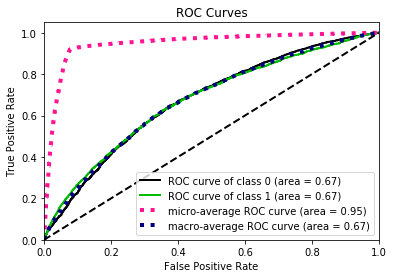

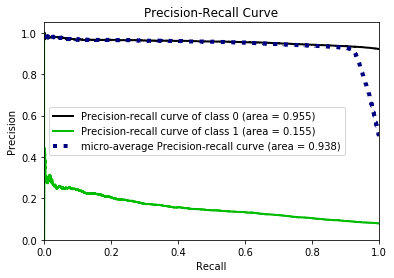

In [67]:
#Using Logistic Regression
lr = LogisticRegression()
model_eval(lr,X_train,y_train,X_test,y_test)

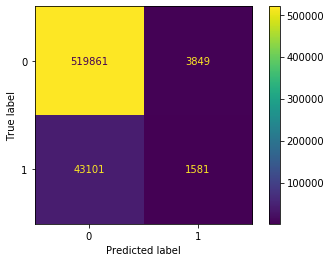

Classification Report: 
               precision    recall  f1-score   support

           0      0.923     0.993     0.957    523710
           1      0.291     0.035     0.063     44682

    accuracy                          0.917    568392
   macro avg      0.607     0.514     0.510    568392
weighted avg      0.874     0.917     0.887    568392



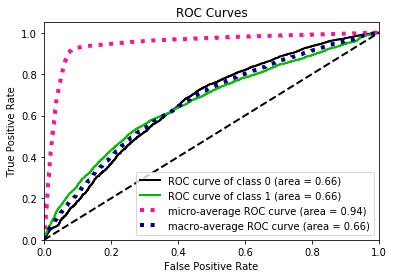

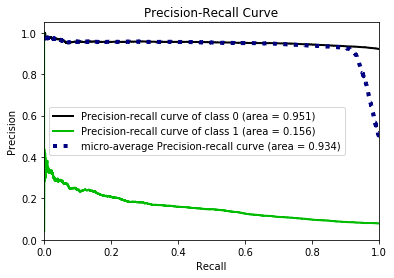

In [68]:
#sekarang kita coba menggunakan Naive Bayes
nb = GaussianNB()
model_eval(nb,X_train,y_train,X_test,y_test)

In [69]:
#Sekarang kita coba menggunakan KNN
# knn = KNeighborsClassifier()
# model_eval(knn,X_train,y_train,X_test,y_test)

In [70]:
#Sekarang kita coba Random Forest
# rf = RandomForestClassifier()
# model_eval(rf,X_train,y_train,X_test,y_test)

/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


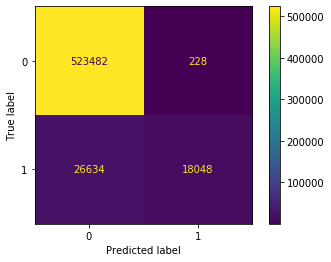

Classification Report: 
               precision    recall  f1-score   support

           0      0.952     1.000     0.975    523710
           1      0.988     0.404     0.573     44682

    accuracy                          0.953    568392
   macro avg      0.970     0.702     0.774    568392
weighted avg      0.954     0.953     0.943    568392



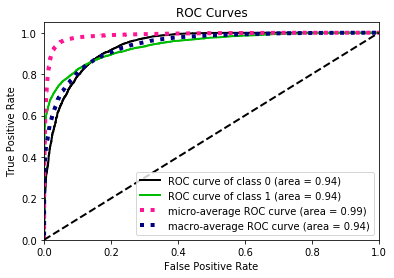

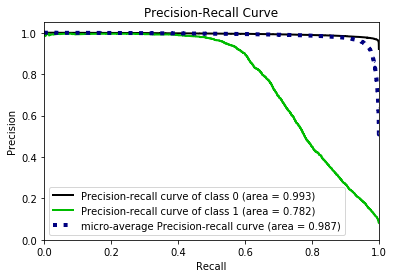

In [71]:
#Sekarang kita coba menggunakan XGBoost
xgb = XGBClassifier()
model_eval(xgb,X_train,y_train,X_test,y_test)

Dapat dilihat pada model - model di atas yang terbaik adalah XGBoost karena RandomForrest overfit pada data kita, maka saya akan memilih XGBoost. Namun bisa dilihat pada Performance metrix bahwa Recall nya sangat kecil, maka saya akan menggunakan scoring F-1 score untuk keduanya optimal.

# 4. MODEL TUNING

In [80]:
#kita membuat function opmitasi, disinia saya menggunakan GridSearchCV
def model_opt(clf, params,X_train,y_train,X_test,y_test ):
    # Load GridSearchCV
    search = RandomizedSearchCV(estimator=clf,
                          param_distributions=params,
                          scoring = 'f1',
                          n_jobs = -1,
                          cv = 3,
                          verbose=True)

    # Train search object
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    best_model = best.fit(X_train, y_train)
    
    #### TEST

    y_test_ypred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:,-1]
    y_probas = best_model.predict_proba(X_test)
    
    print('Best parameters: \n',search.best_params_)
    print('='*70)
    #Confussion Matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    #ROC Curve
    #fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #PR Curve
    skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(16,9))
    plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.62719233 0.         0.0311504  0.64258478 0.85437314 0.18557363
 0.11722662 0.01792023        nan 0.44930887]
  category=UserWarning
/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters: 
 {'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.2, 'colsample_bytree': 0.3}


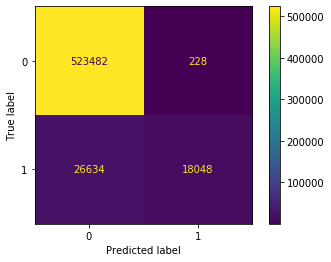

Classification Report: 
               precision    recall  f1-score   support

           0      0.981     0.998     0.990    523710
           1      0.977     0.773     0.863     44682

    accuracy                          0.981    568392
   macro avg      0.979     0.886     0.926    568392
weighted avg      0.981     0.981     0.980    568392



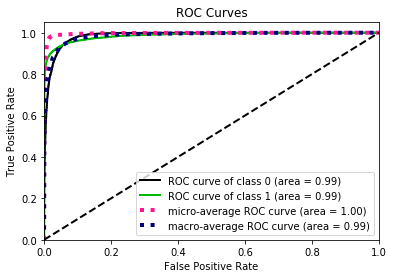

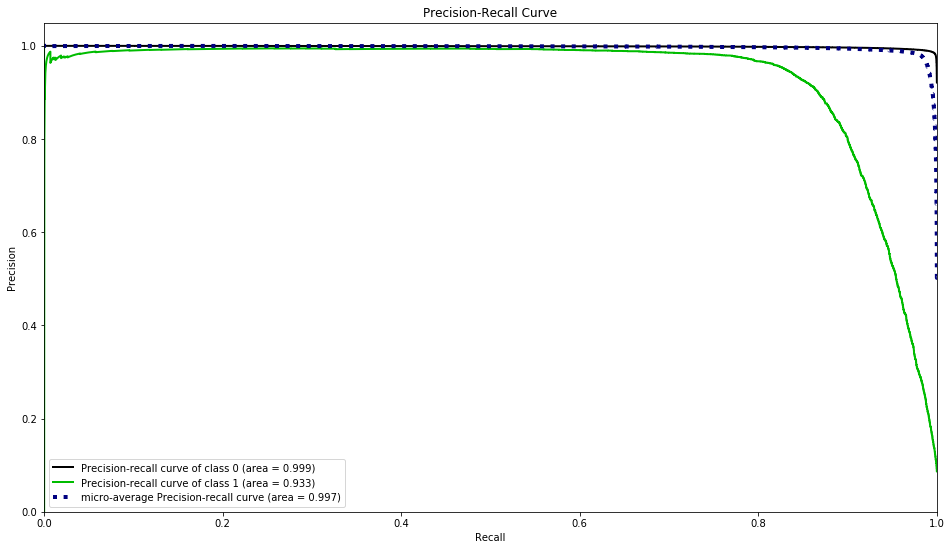

In [81]:
params ={"learning_rate"    : [0.05, 0.10, 0.15, 0.3, 0.5] ,
         "max_depth"        : [ 3, 4, 5, 6, 7, 8],
         "min_child_weight" : [ 1, 3, 5, 7, 9, 15 ],
         "gamma"            : [ 0.0, 0.1, 0.2, 0.5 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5,1,1.5] }

model_opt(xgb, params, X_train, y_train, X_test, y_test)

Setelah dilakukan RandomizedSearchCV maka di dapat parameter terbaik : 

{'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.5}

In [82]:
#sekarnag kita coba pada model setelah ditunning
XGBClassifier.get_xgb_params(xgb)

#model_eval(xgb_tune,X_train,y_train,X_test,y_test)

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

/home/administrator/REJA/credit-risk-modelling/CRM/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:41] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[16:20:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


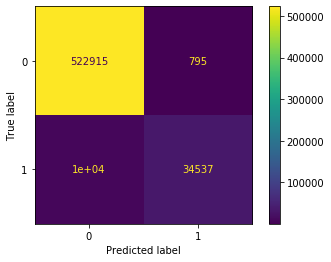

Classification Report: 
               precision    recall  f1-score   support

           0      0.981     0.998     0.990    523710
           1      0.977     0.773     0.863     44682

    accuracy                          0.981    568392
   macro avg      0.979     0.886     0.926    568392
weighted avg      0.981     0.981     0.980    568392



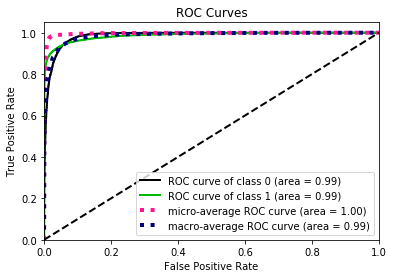

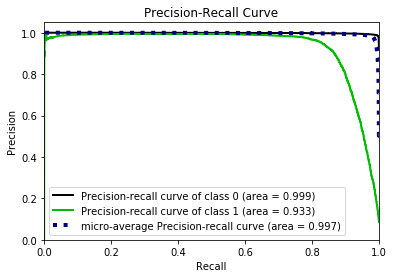

In [83]:
xgb_tune = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
                        learning_rate=0.5, max_delta_step=0, max_depth=8,
                        min_child_weight=1, n_estimators=100, n_jobs=8,gpu_id=0,
                        objective='binary:logistic', random_state=0,
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        subsample=1, verbosity=1)
model_eval(xgb_tune, X_train, y_train, X_test, y_test)

Ada peningkatan pada Recall average yang sebelumnya 70 % menjadi 88.6 %, antara Recall dan Precision akan ada trade-off, oleh karena itu pada scoring di CV saya menggunakan metric f1-score untuk mengharmonikan keduanya, sehingga ada penikatan di F1-score menjadi 98.1 %. perlu diingat bahwa dataset ini imbalance, dapat memprediksi dengan Recall sebesar 88.6 % dan F1-score 98.1 persen menurut saya merupakan model yang bagus.

# 5. KESIMPULAN

Dari semua tahapan pembuatan model di atas, ada beberapa kesimpulan yang bisa diambil yaitu :

1. Model terbaik adalah XGBoost dengan Micro Average PR AUC 99.7 %, Recall 88.6 %, Precission 97.9 % hasil paramter tunning sebagai berikut:
    - colsample_bytree: 0.3,
    - gamma: 0.2,
    - learning_rate: 0.5,
    - max_depth: 8,
    - min_child_weight: 1
2. 10 Variabel yang relefan atau berpengaruh terhadap target secara berurutan adalah:
    1. EXT_SCORE_2
    2. EDUCATION
    3. PRICE
    4. DAYS_WORK
    5. DAYS_AGE
    6. GENDER_F
    7. DAYS_ID_CHANGE
    8. ANNUITY
    9. CONTRACT_TYPE
    10. DAYS_REGISTRATION